# Previous lessons

## Plotting data with different units

### Imports, loading, functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
## Customization options
# plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
# Import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

In [3]:
def format_xdates(ax, fig=None, xtick_fontweight='bold', title=None):
    """Formats x-axis with minor ticks every 3 months, and major ticks every year.
    Includes different grid options for visibility."""
    # Create the locator to place ticks every 3 months
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    # For major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    # Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=xtick_fontweight)
    
    # Customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    # Customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)

    # Making major-minor gridlines visually distinct
    ax.grid(which='major', axis='x', color='k')
    ax.grid(which='minor', axis='x', ls=':')
    if fig is None:
        fig = ax.get_figure()
    # Rotate dates
    fig.automft_xdate(which='major', rotation=90, ha='center')
    return fig, ax 
    

### Loading and preparing data

**Corona Virus Time Series - Cases**

In [4]:
df = pd.read_csv("Data/covid_us_county.csv")
display(df.head())
df.info()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017826 entries, 0 to 3017825
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   fips        float64
 1   county      object 
 2   state       object 
 3   lat         float64
 4   long        float64
 5   date        object 
 6   cases       int64  
 7   state_code  object 
 8   deaths      int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 207.2+ MB


- This data is already long-form, so preprocessing will be faster.
- Do a state-wise analysis, combining values in all counties for each state.

In [5]:
df['state_code'].unique()

array(['AL', 'AK', nan, 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

Examine the null value in the list of states

In [6]:
check = df[df['state_code'].isna()]
check

,fips,county,state,lat,long,date,cases,state_code,deaths
92106,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-22,0,NaN,0
92107,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-23,0,NaN,0
92108,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-24,0,NaN,0
92109,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-25,0,NaN,0
92110,60.0,NaN,American Samoa,-14.2710,-170.1320,2020-01-26,0,NaN,0
...,...,...,...,...,...,...,...,...,...
2718025,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-08,21103,NaN,119
2718026,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-09,21103,NaN,119
2718027,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-10,21103,NaN,119
2718028,78.0,NaN,Virgin Islands,18.3358,-64.8963,2022-07-11,21175,NaN,119


In [7]:
check['state'].unique()

array(['American Samoa', 'Diamond Princess', 'District of Columbia',
       'Grand Princess', 'Guam', 'Northern Mariana Islands',
       'Puerto Rico', 'Virgin Islands'], dtype=object)

- There were several cases in American Territories, along with some on cruise liners. Group these together under a single "cruise" classifier and add a code for the others

In [8]:
df.loc[ df['state']=='American Samoa', 'state_code'] = 'AS'
df.loc[ df['state']=='District of Columbia', 'state_code'] = "DC"
df.loc[ df['state']== 'Guam', 'state_code'] = "GU"
df.loc[ df['state']== 'Northern Mariana Islands ', 'state_code'] = "MP"
df.loc[ df['state']=='Puerto Rico', 'state_code'] = "PR"
df.loc[ df['state']=='Virgin Islands', 'state_code'] = "VI"
df.loc[ (df['state']=='Diamond Princess') | (df['state']=='Grand Princess'), 'state_code'] = "CR"
# Confirm additions to state column
df['state_code'].unique()

array(['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'CR', 'DC',
       'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
       'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH',
       'NJ', 'NM', 'NY', 'NC', 'ND', nan, 'OH', 'OK', 'OR', 'PA', 'PR',
       'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VI', 'VA', 'WA', 'WV',
       'WI', 'WY'], dtype=object)

**Prepare Datetime Index**

In [9]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,fips,county,state,lat,long,cases,state_code,deaths
date,,,,,,,,
2020-01-22,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-23,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-24,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-25,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-26,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
...,...,...,...,...,...,...,...,...
2022-07-08,56045.0,Weston,Wyoming,43.839612,-104.567488,1667,WY,19
2022-07-09,56045.0,Weston,Wyoming,43.839612,-104.567488,1667,WY,19
2022-07-10,56045.0,Weston,Wyoming,43.839612,-104.567488,1667,WY,19


### Visualizing Time Series with Different Magnitudes

**Group data by state**

In [10]:
# Drop unneeded cols
df = df.drop(columns=['fips', 'lat', 'long'])

In [11]:
## Resample with daily freq and group county data together by state_code.
## Aggregate data with .sum() for total # cases per state per day
# Resample as daily freq
df_ts = df.groupby('state_code').resample("D").sum()
df_ts

C:\Users\Malue\AppData\Local\Temp\ipykernel_9860\3056714314.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ts = df.groupby('state_code').resample("D").sum()


cases  deaths
state_code date                      
AK         2020-01-22       0       0
           2020-01-23       0       0
           2020-01-24       0       0
           2020-01-25       0       0
           2020-01-26       0       0
...                       ...     ...
WY         2022-07-08  165619    1834
           2022-07-09  165619    1834
           2022-07-10  165619    1834
           2022-07-11  165619    1834
           2022-07-12  167386    1845

[50568 rows x 2 columns]

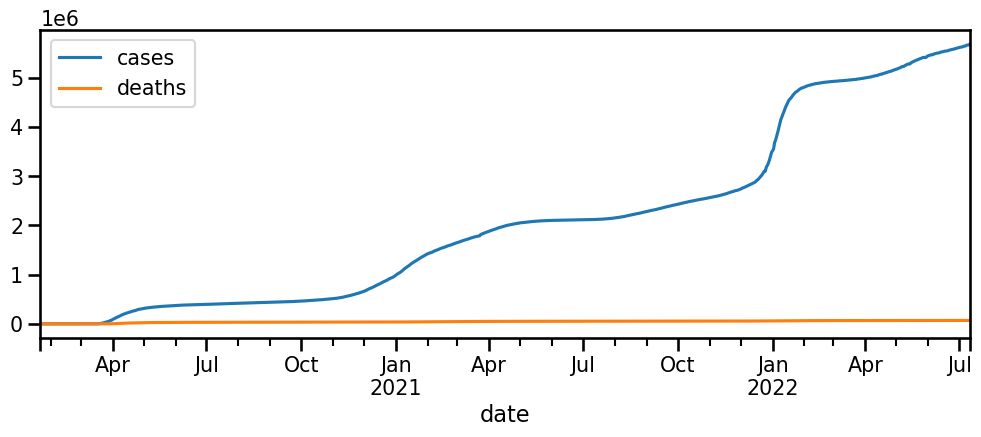

In [12]:
# Visualize one state, viewing both cases and deaths in the same figure
state_ts = df_ts.loc['NY'].copy()
ax = state_ts.plot();

- This figure makes it difficult to view the number of deaths because the line is so much smaller in terms of scale.
- A way to address this is to use two different axis measurements.

**Using twin axes**
- To use twin axes, start with making a fig and ax. The best way is using plt.subplots()
- After there is an ax, save a new ax from ax.twin()

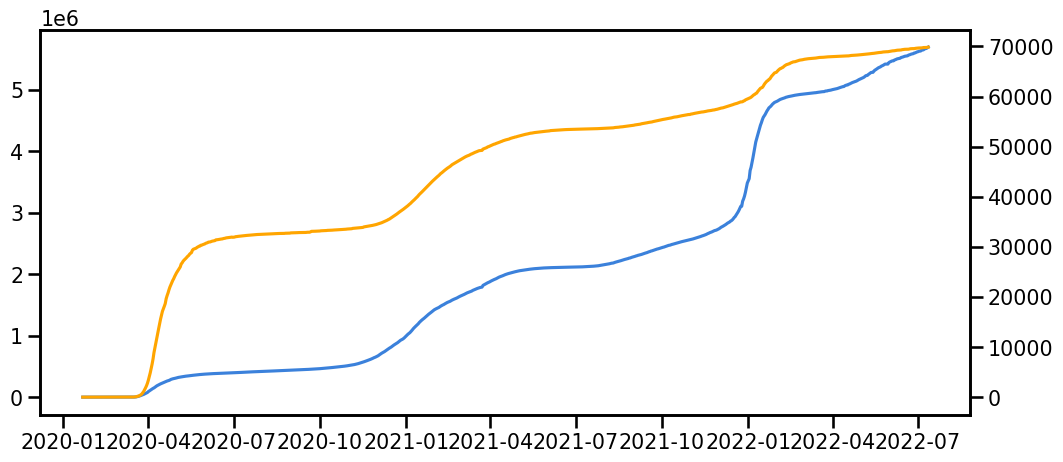

In [13]:
fig, ax1 = plt.subplots(figsize=(12,5))
## Plot first line on original ax
ax1.plot(state_ts.index, state_ts['cases'] ,color='#3b81db',label='Cases')
# Make twin axis and plot second line
ax2 = ax1.twinx()
ax2.plot(state_ts.index ,state_ts['deaths'],label='Deaths',color='orange')

In [14]:
# How many countries does our data cover?
melted['Country/Region'].nunique()

NameError: name 'melted' is not defined

- We can combine the use of .groupby and .resample("D") to get results group-wise
- By doing this, we will end with an index with two columns: a MultiIndex
    - When using .resample we must use an aggregate method, however, in this instance any agg method will return the same total so it doesn't matter which we pick. In the example here, we use .sum()

In [ ]:
df_ts = melted.groupby('Country/Region').resample("D").sum()
df_ts

In [ ]:
df_ts.head().index

- However, we have now retained our ability to locate information by country.

In [ ]:
df_ts.loc['Afghanistan']

- Although trends in both lines are now visible, there is still room for improvement.

**Adding a legend to twin axis**
- Once there are two axes in one graph, legends become more difficult to use. The second legend to be called will obscure the first. There is a multi-step workaround to this problem
- To use a legend with twin axes:
    - Manually reconstruct a legend by giving ax1.legend() the lines, and labels for the lines
        - Get the lines themselves using: `lines=ax1.get_lines() + ax2.get_lines()`
        -  Get labels using: `labels = [l.get_label() for l in lines]`
    - Then use `ax1.legend(lines, labels)` to add the legend

In [ ]:
## Solution for having two legends
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(state_ts.index, state_ts['cases'], color='#3b81db', label='Cases')
ax1.set_ylabel("# of Total Cases")
# Make twin axis
ax2 = ax1.twinx()
ax2.plot(state_ts.index, state_ts['deaths'], label='Deaths', color='orange')
ax2.set_ylabel("# of Total Deaths")
# Removing the grids
ax1.grid(False)
ax2.grid(False)
# Making joined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc=0);
fig.autofmt_xdate()

- The legend is a necessity and looks satisfactory. Next is moving on to formatting the large tick values in a similar fashion as formatting date ticks.
- Before moving on to more customization, recap the previous work as a reusable function.

In [ ]:
def plot_compare_cols(state_ts, col1='cases', color1='#3b81db',
                      col2='deaths', color2='orange',
                      ylabel1='# of Total Cases', ylabel2='# of Total Deaths',
                      figsize=(12,5)):
    # Solution for having two legends
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(state_ts.index, state_ts[col1], color=color1, label=col1.title())
    ax1.set_ylabel(ylabel1)
    # Make twin axis
    ax2 = ax1.twinx()
    ax2.plot(state_ts.index, state_ts[col2], label=col2.title(), color=color2)
    ax2.set_ylabel(ylabel2)
    # Remove the grids
    ax1.grid(False)
    ax2.grid(False)
    # Making a joined legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc=0);
    fig.autofmt_xdate()
    return fig, (ax1, ax2)

In [ ]:
fig, (ax1, ax2) = plot_compare_cols(state_ts)

### Formatting non-date ticks using matplotlib.ticker

**Tick Formatting - Large #'s**

In [ ]:
# The first of two options being covered is StrMethodFormatter, the other being FuncFormatter
import matplotlib.ticker as mticks

#### StrMethodFormatter

- Uses Python string format codes to change the tick label text
- Provide a string format that looks similar to an f-string; uses {} that contain a variable and : followed by a format code
- In this example, clean up y-axis ticks by:
    - Add a , separator for thousands
    - Show zero decimal places

In [ ]:
str_fmt = mticks.StrMethodFormatter("{x:,.0f}")
str_fmt

In [ ]:
fig, (ax1, ax2) = plot_compare_cols(state_ts)
ax1.yaxis.set_major_formatter(str_fmt)
ax2.yaxis.set_major_formatter(str_fmt)

#### FuncFormatter

- The second option for tick formatting is more involved and requires the creation of a function that accepts `x` and `pos` values
- It then returns a string with the desired tick label for each x
- To use for FuncFormatter:
    - Create a function that accepts 2 arguments: x and pos
    - Calculate whatever modification to x is required
    - Use f-strings and format codes to specify how to change x

**Tip: Writing large numbers in Python**
- Python will accept numbers written as regular values: 1000000
- Scientific notation: 1e6
- With underscores: 1_000_000

In [ ]:
# Custom functions for formatting
def millions(x, pos):
    """function for use with matplotlib FuncFormatter - formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x, pos):
    """function for use with matplotlib FuncFormatter - formats money in thousands"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

In [ ]:
fig, (ax1, ax2) = plot_compare_cols(state_ts)
# Set the axis' major formatter
ax1.yaxis.set_major_formatter(fmt_mill)
ax2.yaxis.set_major_formatter(fmt_thous)

#### Combining tick formatting with date formatting

In [ ]:
# Create locator to place ticks every 3 months
loc_3months = mdates.MonthLocator(interval=3)
fmt_months = mdates.DateFormatter("%b")
# Major year ticks
loc_year = mdates.YearLocator()
fmt_year = mdates.DateFormatter("%Y")

In [ ]:
final_fig, (ax1, ax2) = plot_compare_cols(state_ts)
ax1.set_xlim(left=pd.to_datetime('01/2020'))
## Set y-axes major formatters
ax1.yaxis.set_major_formatter(fmt_mill)
ax2.yaxis.set_major_formatter(fmt_thous)
# Customize minor ticks
ax1.xaxis.set_minor_locator(loc_3months)
ax1.xaxis.set_minor_formatter(fmt_months)
# Customize major ticks
ax1.xaxis.set_major_locator(loc_year)
ax1.xaxis.set_major_formatter(fmt_year)
# Make major/minor gridlines visually different
ax1.grid(which='minor', axis='x', lw=1)
ax1.grid(which='major', axis='x', color='k')
final_fig.autofmt_xdate(which='major', rotation=90, ha='center')

# Previous lesson - Time Series Stats

- This lesson covers how to visualize data such as case counts.
- How to convert from cumulative to new values, and the opposite.
- How to smooth a plot and reduce noise by visualzing a rolling average.

## Cumulative Data vs New Data

In [ ]:
# Continue working with the dataset from the previous lessons
df_ts

### Converting Cumulative Values to Delta Values

In [ ]:
# Make a quick visualization to recap the trends from the prior lesson
state_code = 'NY'
state_ts = df_ts.loc[state_code].copy()
axes = state_ts['cases'].plot(figsize=(12,6), title=f"{state_code} State")

- The line is always growing, because the value is the cumulative number of cases. What if we wanted to view only the new cases?

**.diff()**
- We can use ts.diff(), which subtracts the previous row from the next row, turning the cumulative data into New Daily Cases.
    - It calculates the difference between each row and the prior row by default, but differences to other rows can be specified with the use of the periods argument.
    - This will create 1 null value at the beginning of the time series, since there is no prior row to subtract.

In [ ]:
ts_diff = state_ts.diff()
ts_diff

In [ ]:
# Examine the plot of new daily cases
ax = ts_diff['cases'].plot(title='# of Cases - Differenced')

- Much of the data looks jagged and spiky, but time series data will often have random fluctuations that can make it difficult to see larger trends.
- Most of the visuals for things like Covid numbers are likely moving averages, which smooth out the curves.

**Cumulative Sum (.cumsum()) is the inverse of .diff()**
- If starting with day-to-day data, the opposite manipulation can be performed. Converting new values/delta values into a cumulative total can be done with .cumsum()

In [ ]:
ts_sum = ts_diff.cumsum()
ax = ts_sum['cases'].plot(title='Cumulative Sum vs Original Data',
                          label='Summed Diff Data', color='black', lw=5)
state_ts['cases'].plot(ax=ax, label='Original Data', color='red', lw=2, ls='--')
ax.legend();

## Rolling Statistics

**Rolling Average**

In [ ]:
# To demonstrate rolling statistics a smaller date range will be used
ts = ts_diff.loc['10/2021':'7/2022', 'cases'].copy().dropna()
ts.plot();

- Like .resample(), Pandas also has the .rolling() method which is designed for calculating rolling statistics across a fixed window size.
    - .resample() accepts a window size (how many rows/time steps should be averaged together)
    - It also requires some form of aggregation to produce the final data

In [ ]:
# Try calculating a 7-day moving average
window = 7
ts_mean = ts.rolling(window).mean()
ts_mean

- Creating a rolling mean produces null values for the first 7 rows
- Compare the plot of raw daily counts with a 7-day moving average

In [ ]:
ax = ts.plot(label='Raw Daily Counts', lw=1)
ts_mean.plot(label=f'{window} Day Moving Average', ax=ax, lw=3)
ax.legend();

- While not a smooth curve, taking the moving average has made it easier to observe the overall trend without being distracted by random fluctuations.

**Rolling Standard Deviation**

In [ ]:
# Calculate a rolling std()
std = ts.rolling(window).std()
std

In [ ]:
# Calculate the values found within 1 std of the mean
ts_stats = pd.DataFrame({'mean':ts_mean,
                         'mean+std': ts_mean+std,
                         'mean-std': ts_mean-std})
ts_stats = ts_stats.dropna()
ts_stats

In [ ]:
# Plot the rolling mean +/- the rolling std
ax = ts_stats.plot(y='mean', lw=2)
ts_stats.plot(y='mean+std', color='g', lw=0.5, ax=ax)
ts_stats.plot(y='mean-std', color='g', lw=0.5, ax=ax)

In [ ]:
# The area between two sets of values can be filled in using ax.fill_between
ax = ts_stats.plot(y='mean', lw=2)
ax.fill_between(ts_stats.index, ts_stats['mean+std'], ts_stats['mean-std'],
                color='limegreen', alpha=0.5, zorder=0, label='mean+/-std');
ax.legend();

# Normalizing Time Series

- This lesson will cover how to normalize time series data for comparison, for both percent change and population.

### Creating dataframes for normalization and comparison

In [16]:
# Define each state's cases
ny_cases = df_ts.loc['NY', 'cases']
ky_cases = df_ts.loc['KY', 'cases']

In [17]:
# Create a dataframe with each state's cases as a col
compare_ts = pd.DataFrame({'KY':ky_cases,
                           'NY':ny_cases})
compare_ts

,KY,NY
date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,0,0
...,...,...
2022-07-08,1414766,5661360
2022-07-09,1414766,5665385
2022-07-10,1414766,5668645


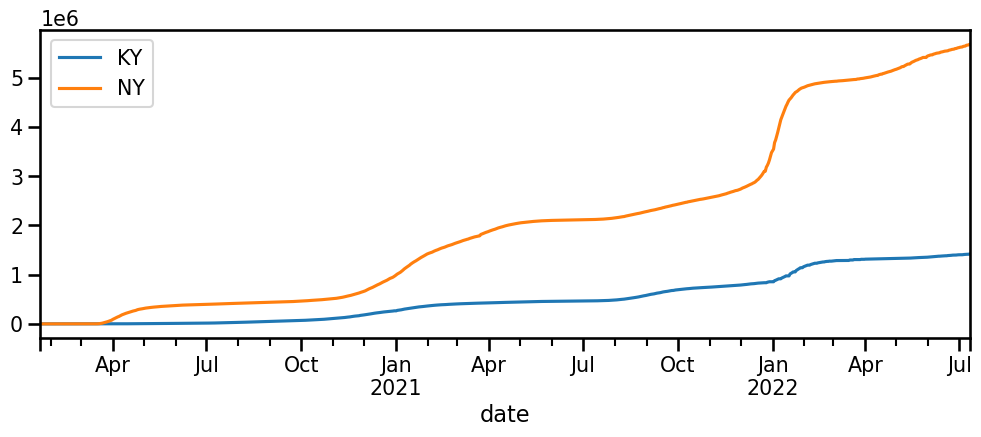

In [18]:
compare_ts.plot();

- It's clear NY has more cases than KY, but try examining non-cumulative values for comparison.

In [19]:
compare_diff = compare_ts.diff().dropna()
compare_diff

,KY,NY
date,,
2020-01-23,0.0,0.0
2020-01-24,0.0,0.0
2020-01-25,0.0,0.0
2020-01-26,0.0,0.0
2020-01-27,0.0,0.0
...,...,...
2022-07-08,2143.0,15343.0
2022-07-09,0.0,4025.0
2022-07-10,0.0,3260.0


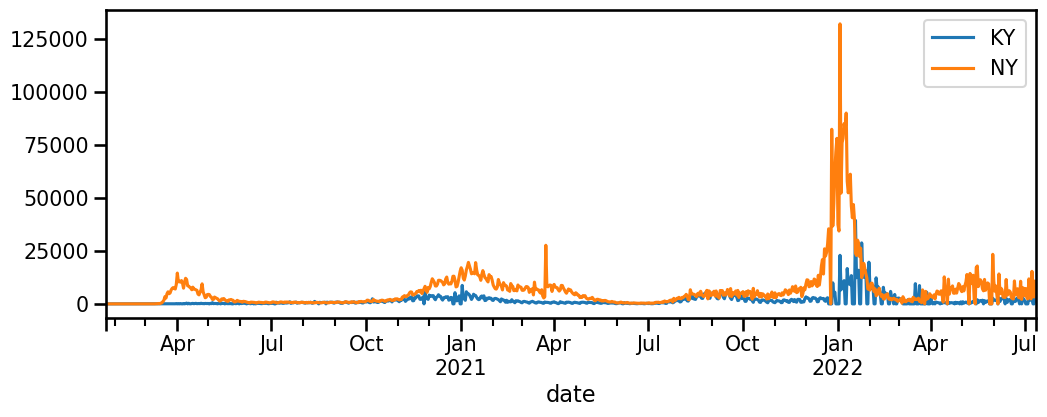

In [20]:
compare_diff.plot();

- Non-cumulative values don't show any hidden trends compared to cumulative, just that NY has significantly more cases.
- However, how does this compare to the total population? Are the percentage of infections similar?

**ts.pct_change()**

In [21]:
# Find the percentage change from the previous day, displayed as a ratio
compare_pct = compare_ts.pct_change(freq='D')
compare_pct

,KY,NY
date,,
2020-01-22,NaN,NaN
2020-01-23,NaN,NaN
2020-01-24,NaN,NaN
2020-01-25,NaN,NaN
2020-01-26,NaN,NaN
...,...,...
2022-07-08,0.001517,0.002717
2022-07-09,0.000000,0.000711
2022-07-10,0.000000,0.000575


In [22]:
# To get the ratio as a percentage, multiply by 100
compare_pct = compare_ts.pct_change(freq='D')*100
compare_pct

,KY,NY
date,,
2020-01-22,NaN,NaN
2020-01-23,NaN,NaN
2020-01-24,NaN,NaN
2020-01-25,NaN,NaN
2020-01-26,NaN,NaN
...,...,...
2022-07-08,0.151704,0.271749
2022-07-09,0.000000,0.071096
2022-07-10,0.000000,0.057542


In [23]:
# Cut out some of the early data to focus on the spikes and noticable changes
plot_ts = compare_pct.loc['07/2021':]
plot_ts

,KY,NY
date,,
2021-07-01,0.035041,0.018487
2021-07-02,0.034384,0.023778
2021-07-03,0.039958,0.013517
2021-07-04,0.016320,0.016539
2021-07-05,0.015888,0.017576
...,...,...
2022-07-08,0.151704,0.271749
2022-07-09,0.000000,0.071096
2022-07-10,0.000000,0.057542


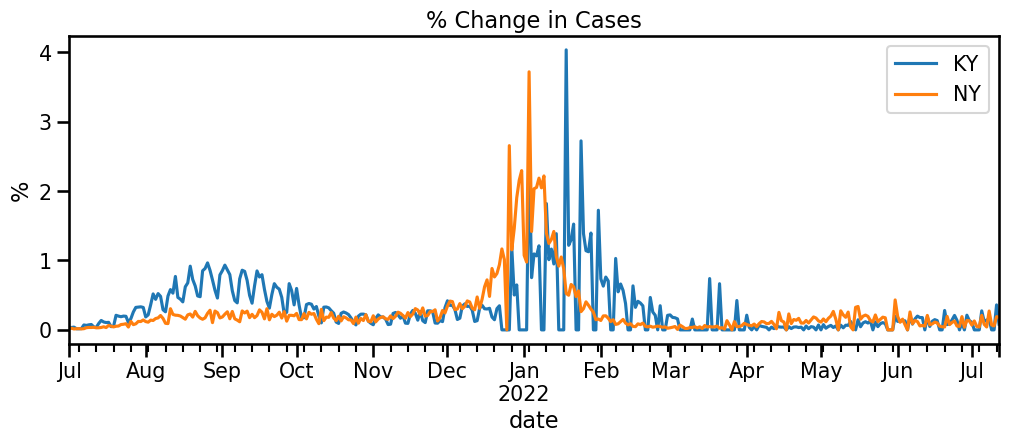

In [24]:
ax = plot_ts.plot(title='% Change in Cases', ylabel='%');

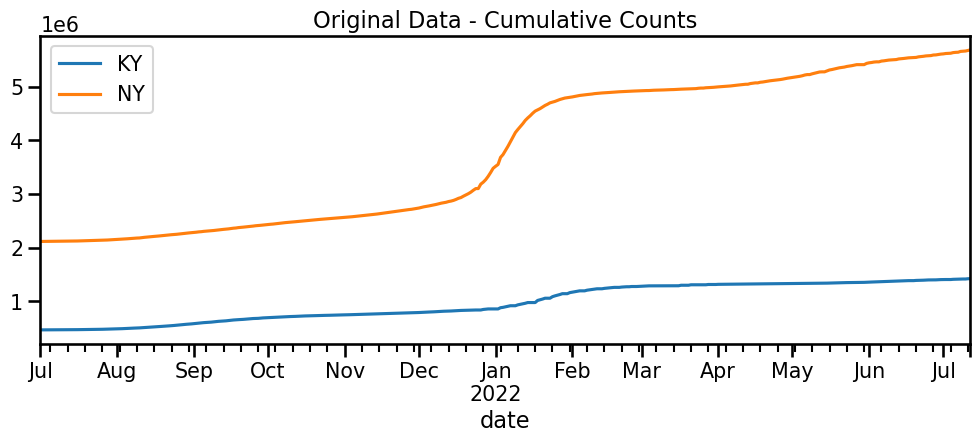

In [25]:
# Generate a rolling mean and compare against original data
compare_ts.loc['07/2021':].plot(title='Original Data - Cumulative Counts');

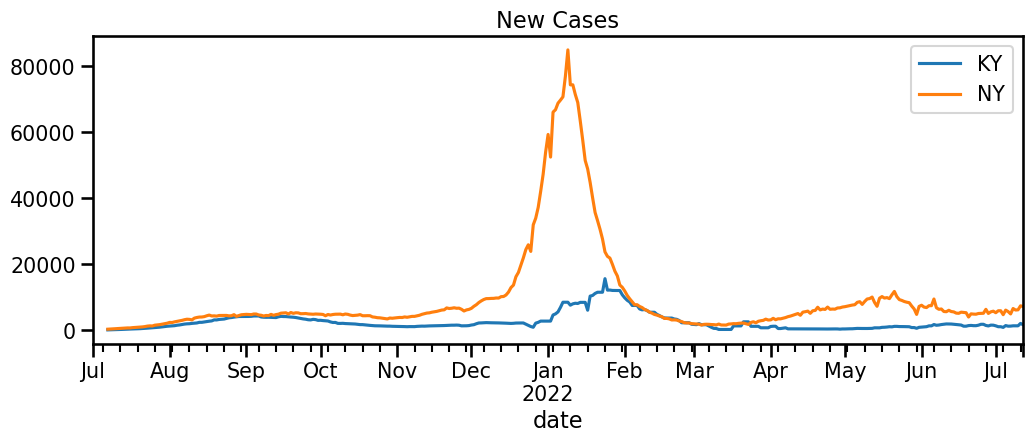

In [26]:
compare_diff.loc['07/2021':].rolling(7).mean().plot(title='New Cases');

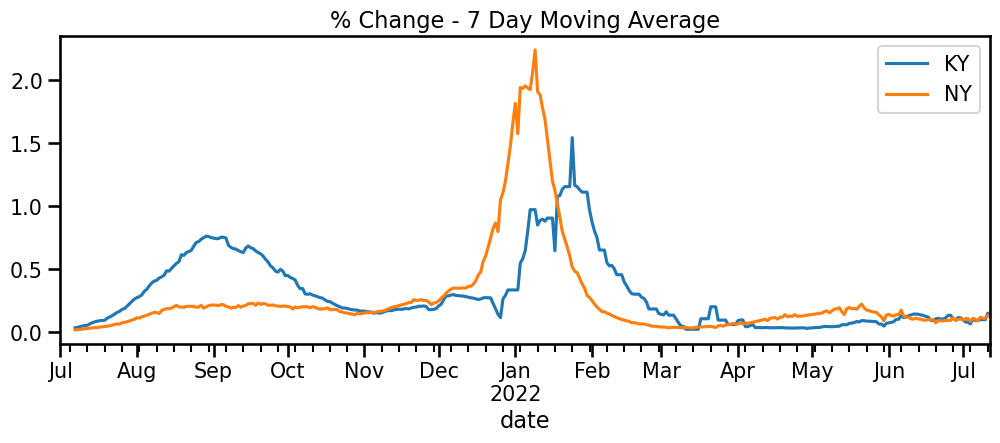

In [28]:
plot_ts = compare_pct.loc['07/2021':].rolling(7).mean()
plot_ts.plot(title='% Change - 7 Day Moving Average');

### Normalizing by Population

- In the below example, normalize the case counts using the state population.
- A common approach is to normalize the values per 100,000 people.
- Because this Covid dataset does not include population, it must be obtained from another data set and merged with the Covid data.
- Use the Census data from Kaggle 2019

In [29]:
us_pop = pd.read_csv('Data/2019_Census_US_Population_Data_By_State_Lat_Long.csv')
us_pop.head()

,STATE,POPESTIMATE2019,lat,long
0,Alabama,4903185,32.377716,-86.300568
1,Alaska,731545,58.301598,-134.420212
2,Arizona,7278717,33.448143,-112.096962
3,Arkansas,3017804,34.746613,-92.288986
4,California,39512223,38.576668,-121.493629


- Matching state population with the right abbreviation requires either returning to the original raw data and extracting the mapping of Statename:state,
- OR,
- Acquire another file that has this information already paired.

In [30]:
state_lookup = df[['state', 'state_code']]
state_lookup = state_lookup.drop_duplicates(subset=['state']).reset_index(drop=True)
state_lookup.head()

,state,state_code
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR


In [31]:
# Merge the US pop with state lookup
merged_pop = pd.merge(us_pop[['STATE', 'POPESTIMATE2019']], state_lookup, left_on='STATE',
                      right_on='state')
# merged_pop = merged_pop.drop(columns='state').set_index('state_code')
state_pop = merged_pop.set_index('state_code')['POPESTIMATE2019']
state_pop.head()

state_code
AL     4903185
AK      731545
AZ     7278717
AR     3017804
CA    39512223
Name: POPESTIMATE2019, dtype: int64

In [32]:
# Example calc for KY
compare_ts['KY']/state_pop.loc['KY']*100_000

date
2020-01-22        0.000000
2020-01-23        0.000000
2020-01-24        0.000000
2020-01-25        0.000000
2020-01-26        0.000000
                  ...     
2022-07-08    31666.731204
2022-07-09    31666.731204
2022-07-10    31666.731204
2022-07-11    31780.795058
2022-07-12    31807.095103
Freq: D, Name: KY, Length: 903, dtype: float64

In [33]:
# Finally use a for loop to calculate the population
compare_pop = compare_ts.copy()
for col in compare_ts.columns:
    compare_pop[col] =( compare_pop[col] / state_pop.loc[col]) * 100_000
compare_pop

,KY,NY
date,,
2020-01-22,0.000000,0.000000
2020-01-23,0.000000,0.000000
2020-01-24,0.000000,0.000000
2020-01-25,0.000000,0.000000
2020-01-26,0.000000,0.000000
...,...,...
2022-07-08,31666.731204,29101.921237
2022-07-09,31666.731204,29122.611536
2022-07-10,31666.731204,29139.369394


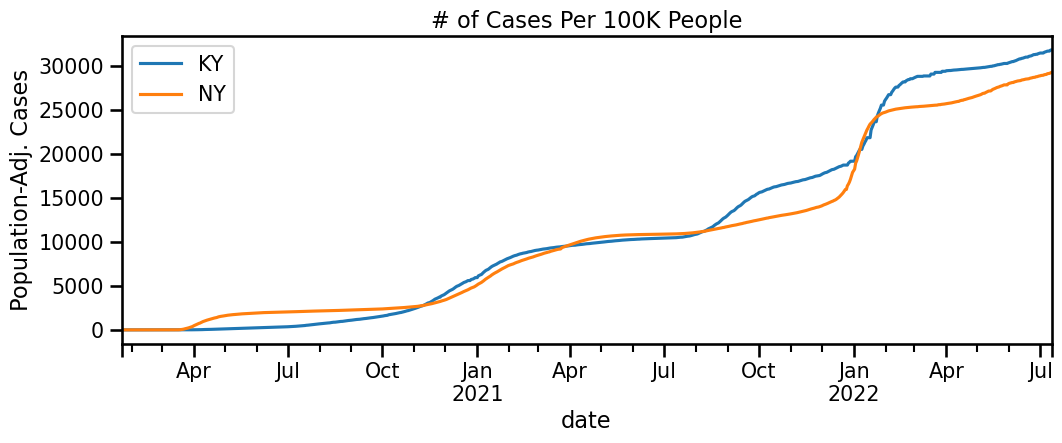

In [39]:
ax = compare_pop.plot(ylabel='Population-Adj. Cases', title='# of Cases Per 100K People');
# ax.yaxis.set_major_formatter(str_fmt)

### Summary

- When comparing groups of different sizes, the data must be normalized to make meaningful comparisons.
- This lesson covered two methods of data normalization for comparison:
    - Normalize by percentage
    - Normalize by cases per population (cases per 100K in this example)